In [475]:
import numpy as np
from scipy.io import wavfile
import matplotlib.pyplot as plt
import matplotlib as mpl
from importlib import reload
from vosk import Model
from Signal_Analysis.features.signal import get_HNR
from scipy import signal


# tools work in progress
import tools

reload(tools)

plt.style.use("dark_background")
mpl.rcParams["lines.linewidth"] = 0.5
plt.close("all")

In [476]:
import os
from librosa import load

examples_dir = "example_speech_mp3/svenska"
filenames = os.listdir(examples_dir)
print(filenames)
audios = []
for f in filenames:
    y, Fs = load(os.path.join(examples_dir, f), sr=None)
    audios.append(y)

wavfile.write("wav_examples/svenska_combo.wav", Fs, tools.stitch_frames(audios))


['common_voice_sv-SE_38528961.mp3', 'common_voice_sv-SE_38528962.mp3', 'common_voice_sv-SE_38528964.mp3', 'common_voice_sv-SE_38528967.mp3', 'common_voice_sv-SE_38528968.mp3', 'common_voice_sv-SE_38543999.mp3', 'common_voice_sv-SE_38544000.mp3', 'common_voice_sv-SE_38544001.mp3', 'common_voice_sv-SE_38544002.mp3', 'common_voice_sv-SE_38544004.mp3', 'common_voice_sv-SE_38544013.mp3', 'common_voice_sv-SE_38544014.mp3', 'common_voice_sv-SE_38544015.mp3', 'common_voice_sv-SE_38544016.mp3', 'common_voice_sv-SE_38544017.mp3', 'common_voice_sv-SE_38568655.mp3', 'common_voice_sv-SE_38568656.mp3', 'common_voice_sv-SE_38568657.mp3', 'common_voice_sv-SE_38568658.mp3', 'common_voice_sv-SE_38568659.mp3', 'common_voice_sv-SE_38568660.mp3', 'common_voice_sv-SE_38568661.mp3', 'common_voice_sv-SE_38568662.mp3', 'common_voice_sv-SE_38568663.mp3', 'common_voice_sv-SE_38568664.mp3', 'common_voice_sv-SE_38568670.mp3', 'common_voice_sv-SE_38568671.mp3', 'common_voice_sv-SE_38568672.mp3', 'common_voice_sv-SE

## preprocess

In [477]:
audio_original_path = "wav_examples/svenska_combo.wav"
_ = tools.preprocess(audio_original_path)


preprocessing svenska_combo


## Speech recognition

In [478]:
audio_path = "audio_preproc/svenska_combo_pp.wav"
Fs, audio = wavfile.read(audio_path)
model_path = "models/vosk-model-small-sv-rhasspy-0.15/"
if "model" not in locals():
    model = Model(model_path)

0 åter ---------------- from 0.42 to 0.87 sec, confidence: 69.46%
1 förvillande --------- from 0.87 to 1.23 sec, confidence: 54.13%
2 vildanden ----------- from 1.23 to 1.53 sec, confidence: 45.87%
3 av ------------------ from 1.56 to 1.68 sec, confidence: 70.12%
4 borås --------------- from 1.68 to 2.19 sec, confidence: 100.00%
5 låg ----------------- from 2.19 to 2.40 sec, confidence: 57.48%
6 högst --------------- from 2.43 to 2.85 sec, confidence: 100.00%
7 på ------------------ from 2.85 to 2.97 sec, confidence: 72.04%
8 agenda -------------- from 2.97 to 3.60 sec, confidence: 64.10%
9 utredaren ----------- from 4.38 to 5.07 sec, confidence: 82.45%
10 ska ----------------- from 5.07 to 5.22 sec, confidence: 100.00%
11 vidare -------------- from 5.22 to 5.61 sec, confidence: 100.00%
12 inhämta ------------- from 5.61 to 6.15 sec, confidence: 100.00%
13 synpunkter ---------- from 6.15 to 6.81 sec, confidence: 100.00%
14 från ---------------- from 6.84 to 7.02 sec, confidence: 100.00

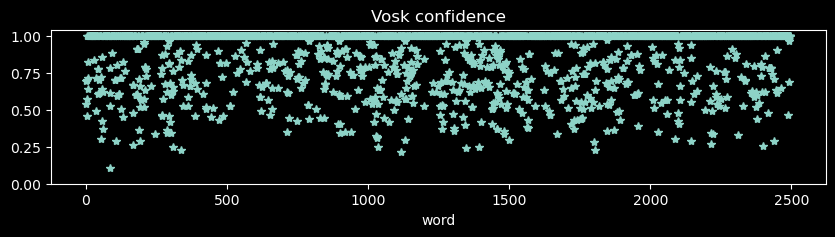

In [479]:
words = tools.rec_vosk(audio_path, model, print_summary=True)

text = " ".join([w["word"] for w in words])


print(text)
plt.figure(figsize=(10, 2))
plt.plot([w["conf"] for w in words], "*")
plt.title("Vosk confidence")
plt.xlabel("word")
plt.ylim(bottom=0)
plt.show()

In [480]:
# get all vowels
for w in words:
    w["vowels"] = tools.checkVowels(w["word"], tools.VOWELS_SV)

for w in words:
    print(w["word"], w["vowels"], str(w["conf"] * 100) + "%")

åter ['å', 'e'] 69.4577%
förvillande ['ö', 'i', 'a', 'e'] 54.1319%
vildanden ['i', 'a', 'e'] 45.8681%
av ['a'] 70.1221%
borås ['o', 'å'] 100.0%
låg ['å'] 57.477000000000004%
högst ['ö'] 100.0%
på ['å'] 72.03960000000001%
agenda ['a', 'e', 'a'] 64.0965%
utredaren ['u', 'e', 'a', 'e'] 82.4505%
ska ['a'] 100.0%
vidare ['i', 'a', 'e'] 100.0%
inhämta ['i', 'ä', 'a'] 100.0%
synpunkter ['y', 'u', 'e'] 100.0%
från ['å'] 100.0%
berörda ['e', 'ö', 'a'] 100.0%
myndigheter ['y', 'i', 'e', 'e'] 100.0%
organisationer ['o', 'a', 'i', 'a', 'i', 'o', 'e'] 100.0%
och ['o'] 100.0%
näringslivsdirektörens ['ä', 'i', 'i', 'i', 'e', 'ö', 'e'] 100.0%
jag ['a'] 100.0%
har ['a'] 100.0%
inte ['i', 'e'] 100.0%
läst ['ä'] 100.0%
något ['å', 'o'] 100.0%
av ['a'] 100.0%
honom ['o', 'o'] 100.0%
och ['o'] 100.0%
känner ['ä', 'e'] 84.1452%
honom ['o', 'o'] 100.0%
således ['å', 'e', 'e'] 100.0%
inte ['i', 'e'] 100.0%
vi ['i'] 100.0%
ska ['a'] 100.0%
förklara ['ö', 'a', 'a'] 100.0%
de ['e'] 49.553999999999995%
på ['å'] 1

## test 1 word

In [481]:
def HNR_short(frames, Fs, n_peaks=-1):
    """get frame index for peaks and hnr per frame"""
    hnr_frames = np.array([get_HNR(f, Fs) for f in frames])
    peaks, _ = signal.find_peaks(hnr_frames)
    peaks = peaks[(-peaks).argsort()[:n_peaks]]  # läskig one-liner
    return peaks, hnr_frames

av
--
frame length    : 640 samples
frame length    : 0.02 seconds
between frames  : 0.02 seconds
number of frames: 20


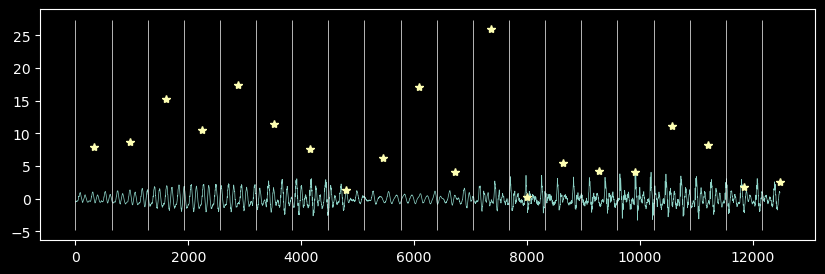

In [482]:
fl = int(0.02 * Fs)
k = 3
print(words[k]["word"])
print("-" * len(words[k]["word"]))
segments, vowels_per_segment = tools.segment_by_words(words, audio, Fs, tools.VOWELS_SV)
x = segments[k] / segments[k].std()
vowels = vowels_per_segment[k]


frames, f_start = tools.split_frames(x, fl, Fs, overlap=0, print_info=True)

peak_frames, hnr_frames = HNR_short(frames, Fs, len(vowels))

plt.figure(figsize=(10, 3))
plt.plot(x)
plt.plot(f_start + int(fl / 2), hnr_frames, "*")
plt.vlines(f_start, *plt.ylim())

plt.show()

In [483]:
grouped = {v: [] for v in tools.VOWELS_SV}
print(vowels)
print(len(frames))
print(len(peak_frames))

if len(peak_frames) == len(vowels):
    for i, v in enumerate(vowels):
        grouped[v].append(frames[peak_frames[i]])

['i', 'a', 'e']
20
3


## all words

In [488]:
grouped = {v: [] for v in tools.VOWELS_SV}
segments, vowels_per_segment = tools.segment_by_words(words, audio, Fs, tools.VOWELS_SV)
for w, segment, vowels in zip(words, segments, vowels_per_segment):
    if w["conf"] >= 1:
        print(w["word"], w["conf"])
        frames, f_start = tools.split_frames(segment, fl, Fs, overlap=0)
        peak_frames, hnr_frames = HNR_short(frames, Fs, len(vowels))
        if len(peak_frames) == len(vowels):
            for i, v in enumerate(vowels):
                grouped[v].append(frames[peak_frames[i]])

audio_out = {}
for v in grouped.keys():
    audio_out[v] = tools.stitch_frames(grouped[v], fade_pow=0.5)
    wavfile.write(f"output/concatenated/concatenated_{v}.wav", Fs, audio_out[v])


borås 1.0
högst 1.0
ska 1.0
vidare 1.0
inhämta 1.0
synpunkter 1.0
från 1.0
berörda 1.0
myndigheter 1.0
organisationer 1.0
och 1.0
näringslivsdirektörens 1.0
jag 1.0
har 1.0
inte 1.0
läst 1.0
något 1.0
av 1.0
honom 1.0
och 1.0
honom 1.0
således 1.0
inte 1.0
vi 1.0
ska 1.0
förklara 1.0
på 1.0
språk 1.0
hon 1.0
hörde 1.0
genom 1.0
dörren 1.0
utan 1.0
ringaste 1.0
upprördhet 1.0
hade 1.0
angreppet 1.0
på 1.0
bara 1.0
det 1.0
är 1.0
inte 1.0
alltid 1.0
fallet 1.0
patienten 1.0
är 1.0
kanske 1.0
medvetslös 1.0
eller 1.0
alltför 1.0
medtagen 1.0
för 1.0
att 1.0
kunna 1.0
ta 1.0
ställning 1.0
till 1.0
frågan 1.0
hela 1.0
straffet 1.0
hos 1.0
den 1.0
felande 1.0
i 1.0
framtiden 1.0
kommer 1.0
allt 1.0
att 1.0
bli 1.0
annorlunda 1.0
till 1.0
den 1.0
här 1.0
kojan 1.0
största 1.0
godset 1.0
i 1.0
och 1.0
är 1.0
därtill 1.0
se 1.0
honom 1.0
men 1.0
hon 1.0
avbröt 1.0
mig 1.0
började 1.0
tala 1.0
om 1.0
andra 1.0
men 1.0
i 1.0
alla 1.0
fall 1.0
lärt 1.0
mig 1.0
vad 1.0
som 1.0
passar 1.0
helst 1.0


In [489]:
vowels_in_text = {v: 0 for v in tools.VOWELS_SV}
for c in tools.checkVowels(text, tools.VOWELS_SV):
    vowels_in_text[c] += 1

print("found vowels:")
for v in grouped.keys():
    print(
        "    ",
        v,
        len(grouped[v]),
        str(round(100 * len(grouped[v]) / vowels_in_text[v], 3)) + "%",
    )


found vowels:
     y 24 36.364%
     å 136 55.51%
     o 260 53.608%
     i 277 49.027%
     ä 135 52.941%
     u 130 56.034%
     ö 104 56.831%
     e 605 51.976%
     a 578 52.785%


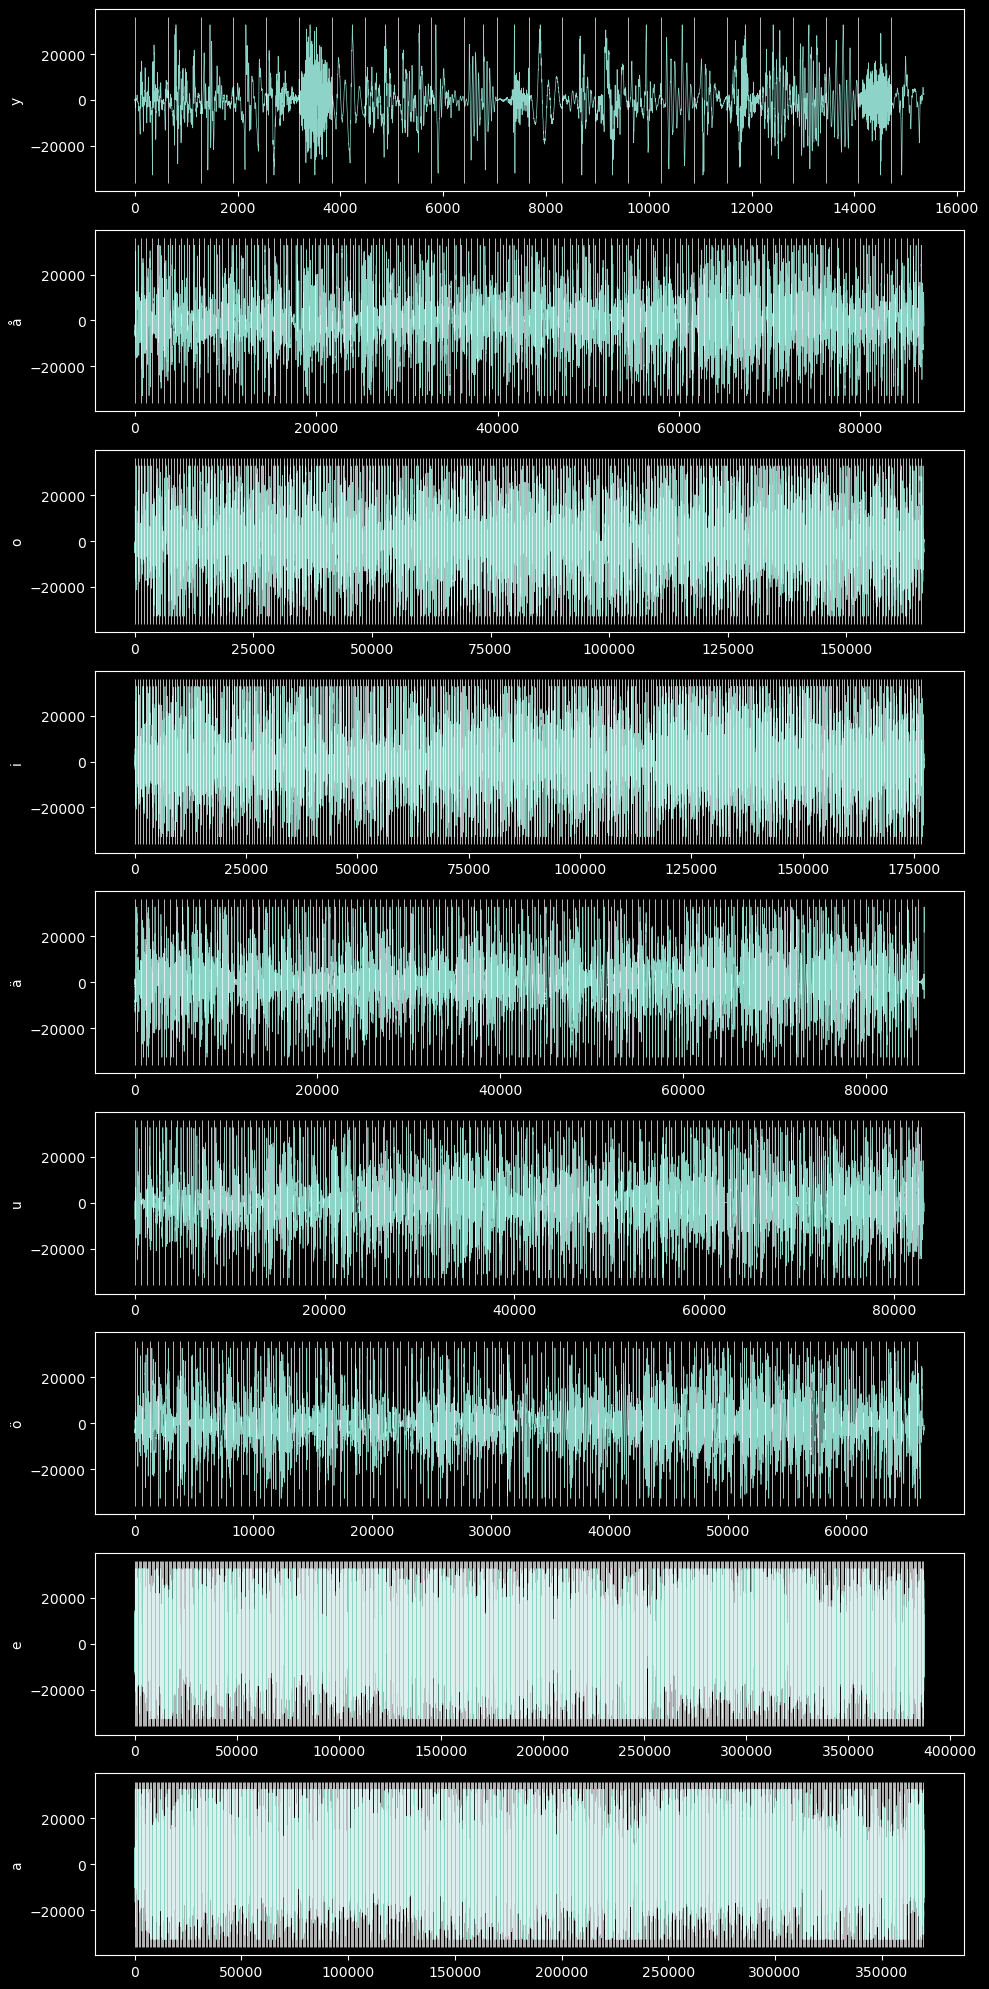

In [490]:
plt.figure(figsize=((10, 20)))
for i, v in enumerate(audio_out.keys()):
    plt.subplot(len(tools.VOWELS_SV), 1, i + 1)
    plt.plot(audio_out[v])
    # plt.xlim(0, 10000)
    plt.vlines(np.arange(0, len(audio_out[v]), fl), *plt.ylim())
    plt.ylabel(v)

plt.tight_layout()
